## Group Information
## Week 3 Track 2
### Tream 4
### members:
Weizhao Wang

Fulin Jiang

Kunwei Song


## Track 2 TODO 1:  Retrieve predicted segmentation mask and estimated joints from pretrained network
 
For the first part of our animation pipeline, we will use the pretrained objection detection model and segmentation method from author's implementation to obtain a segmentation mask for our own drawing. Your first task is:
1. Go to the Github repository https://github.com/facebookresearch/AnimatedDrawings/tree/main, follow the instructions in "animating-your-own-drawing" https://github.com/facebookresearch/AnimatedDrawings/tree/main#animating-your-own-drawing) to obtain a segmentation mask "mask.png", a texture map "texture.png", and locations of detected joint skeleton in "char_cfg.yaml" using the example drawing "garlic.png"
2. Write code to load the segmentation mask and the original image, compose and visualize a masked image using Matplotlib
3. Load detected joint locations, use Matplotlib to visualize the locations and labels of the joints. Visualize the tree hierarchy of the skeleton using lines (See desired output in session slide)
4. Make your own drawing, and repeat step 1-3 

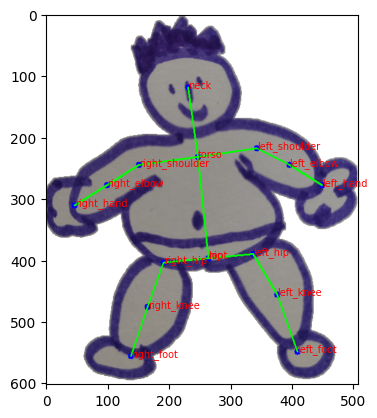

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# load the mask

img = cv2.imread('char1/mask.png')
background = np.bitwise_not(img)
ori_img = cv2.imread('char1/texture.png')
# compute AND to img and ori_img
img = np.bitwise_and(img, ori_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.add(img, background)
plt.imshow(img)

# read the yaml file

import yaml
with open('char1/char_cfg.yaml') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)

# draw the joint
for joint in data['skeleton']:
    cv2.circle(img, tuple(joint['loc']), 5, (0, 0, 255), -1)
    plt.text(joint['loc'][0],joint['loc'][1],joint['name'],color='red',fontsize=7)
plt.imshow(img)

# draw the bone
for node in data['skeleton']:
    if node['parent'] is not None:
        for name in data['skeleton']:
            if name['name'] == node['parent']:
                cv2.line(img, tuple(node['loc']), tuple(name['loc']), (0, 255, 0), 2)
plt.imshow(img)

## Track 2 TODO 2:  2D Mesh Generation using delaunay triangulation
For the second part of our animation pipeline, we need to generate a 2D mesh from our masked image that we can use for rigging during the animation phase. Your task is
1. Generate random points using Poisson Disk Sampling (https://medium.com/@hemalatha.psna/implementation-of-poisson-disc-sampling-in-javascript-17665e406ce1) as points in our mesh
2. Use Delaunay triangulation to generate a 2D triangle mesh from sampled points
3. Visualize the generated 2D mesh using Matplotlib


In [8]:
# load the mask

import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import numpy as np 
from scipy.spatial import Delaunay
import matplotlib.tri as tri
random.seed(1)
img = cv2.imread('char1/mask.png', cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 127, 1, cv2.THRESH_BINARY)
# plt.imshow(img)
# dilate image to generate candidate points
kernel = np.ones((5, 5), np.uint8) 
img_dilation = cv2.dilate(img, kernel, iterations=2)
x, y = np.where(img_dilation == 1)
points = list(np.stack((x, y), axis=-1))
background = np.bitwise_not(img)

# points = []
# for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#         if img[i][j] != 0:
#             points.append([i,j])
# points = list(np.stack(points))



# Poisson Disk Sampling in the mask

# class Point:
#     def __init__(self,x,y):
#         self.X=x
#         self.Y=y
#     def Cal_Distans(self,point):
#         return count_distance(self,point)

def count_distance(p0,p1):
    return np.linalg.norm(p0-p1)

def poissonDiskSampling(points,r):
    # generate tons of random points in interval [0,500][0,600]
    # points = []
    # for i in range(10000):
    #     points.append(Point(random.randint(0,500),random.randint(0,600)))
    i = 0
    while i < len(points):
        j = i+1
        while j<len(points):
            if count_distance(points[i],points[j]) <= r:
                points.pop(j)
                j -= 1
            j += 1
        i += 1
    return points

print(len(points))
points = poissonDiskSampling(points,20)
print(len(points))

165618
449


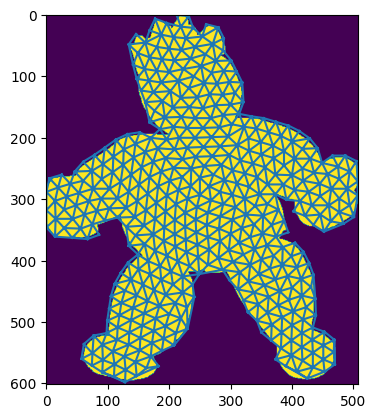

In [10]:
# draw the triangle
Delaunay_Triangles=Delaunay([[point[0],point[1]] for point in points])
x = np.array([point[1] for point in points])
y = np.array([point[0] for point in points])
Triangle = tri.Triangulation(x,y)
xmean = x[Triangle.triangles].mean(axis = 1)
ymean = y[Triangle.triangles].mean(axis = 1)

i = 0
while i < len(Triangle.triangles):
    if background[int(ymean[i]),int(xmean[i])] == 255:
        Triangle.triangles = np.delete(Triangle.triangles,i,axis = 0)
        ymean = np.delete(ymean,i)
        xmean = np.delete(xmean,i)
        i -= 1
        continue
    i += 1

plt.imshow(img)
plt.triplot(Triangle)
plt.show()

# for point in points:
#         cv2.circle(img, (int(point[0]),int(point[1])), 1, (0, 0, 255),0)
#         plt.imshow(img)